# Toxic Comment Classification Challenge

This challenge deals with the detection of toxic behaviour in online conversations, in order to help online discussions to become more productive and fruitful. Data was extracted from comments on Wikipedia’s talk page edits and it's analyzed hereby. 

## Data Analysis

First of all let's take a look at the raw data in order to get a taste of the columns to be expected.

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

train_df = pd.read_csv('data/train.csv', index_col=0)
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


As we can see, we're going to deal with textual data and try to label each online conversation to the consequent classes 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'. Let's see the amount of data we're dealing with by printing the size of the dataset.

In [36]:
train_df.shape

(159571, 7)

Let's analyze the labels, in order to understand what kind of classification problem we have. 

In [37]:
labels_df = train_df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
labels_row_valuecounts = labels_df.sum(axis=1).value_counts(sort=True)
print(labels_row_valuecounts)

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64


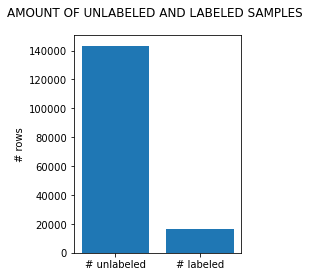

In [38]:
plt.figure(figsize=(3, 4))
plt.suptitle('AMOUNT OF UNLABELED AND LABELED SAMPLES')

plt.bar(['# unlabeled', '# labeled'], [labels_row_valuecounts[0], labels_row_valuecounts[1:].sum()])

plt.ylabel('# rows')
plt.show()

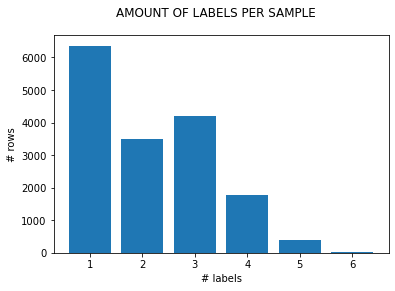

In [39]:
plt.figure(figsize=(6, 4))
plt.suptitle('AMOUNT OF LABELS PER SAMPLE')

plt.bar(labels_row_valuecounts.index[1:], labels_row_valuecounts[1:])

plt.xlabel('# labels')
plt.ylabel('# rows')
plt.show()

In [40]:
labels_column_valuecounts = labels_df.sum(axis=0).sort_values(ascending=False)
labels_column_valuecounts

toxic            15294
obscene           8449
insult            7877
severe_toxic      1595
identity_hate     1405
threat             478
dtype: int64

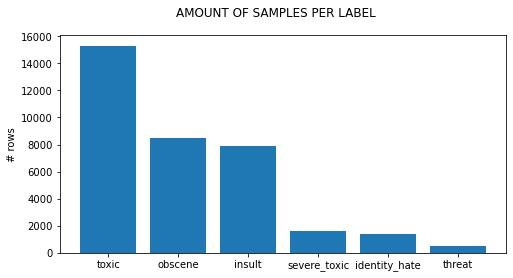

In [41]:
plt.figure(figsize=(8, 4))
plt.suptitle('AMOUNT OF SAMPLES PER LABEL')

plt.bar(labels_column_valuecounts.index, labels_column_valuecounts)

plt.ylabel('# rows')
plt.show()

It's now clear that we're dealing with a multi-label classification task with ~140k non-labeled samples and the remaining ~20k samples to be labeled with one or more classes. One of the problems affecting the dataset is the high imbalance: 
* between labeled and unlabeled examples (with a prevalence of unlabeled examples - ratio 1:7)
* among the different labeled examples (with a prevalence of toxic, obscene and insult labeled examples - ratio 1:2:2:8:8:16)

In [42]:
import requests
from bs4 import BeautifulSoup

html_doc = requests.get('https://www.cs.cmu.edu/~biglou/resources/bad-words.txt')
soup = BeautifulSoup(html_doc.content, 'html.parser')

badwords = soup.get_text().split('\n')[1:-1]
print(badwords[:10])
print(len(badwords))

['abbo', 'abo', 'abortion', 'abuse', 'addict', 'addicts', 'adult', 'africa', 'african', 'alla']
1383


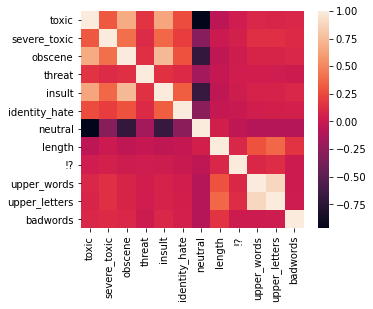

In [43]:
import matplotlib.pyplot as plt

text = train_df['comment_text']

train_df[['neutral']] = labels_df.sum(axis=1).map(lambda x: 1 if x==0 else 0)
train_df[['length']] = text.apply(len)
train_df[['!?']] = text.apply(lambda x: len(x.split('!'))-1 + len(x.split('?'))-1)
train_df[['upper_words']] = text.apply(lambda x: sum(1 for word in x.split(' ') if word.isupper()))
train_df[['upper_letters']] = text.apply(lambda x: sum(1 for letter in x if letter.isupper()))
train_df[['badwords']] = text.apply(lambda x: sum(1 for letter in x.split(' ') if letter in badwords))

plt.figure(figsize=(5,4))
cor = train_df.corr(method='pearson')
sns.heatmap(cor)
plt.show()


From this correlation matrix we can see that badwords could be a good indicator for toxicity vs non-toxicity. We might want to generate a bag-of-words representation and observe if there are clusters of badwords that are used for specific toxic behaviours. 

Let's work out on preprocessing the text in order to try extracting meaningful features from the words. Cleaning the text will involve several steps aiming at increasing the words shared between conversations regardless of their inflection/form. For this reason we will apply several steps consequently:
* lowering of the words (we've seen that the uppercasing is not correlated with any of the interested classes, so we're not losing info with this prep step)
* abbreviations removal (sometimes abbreviations are used in textual conversations, we will try to address the most common abbreviations)
* punctuation removal (not really needed as soon as we're considering words as features)
* number removal (same as punctuation removal)
* tokenization 
* stopwords removal (no semantic usefulness for the toxicity detection task)
* lemmatization (to remove inflection and increase the amount of shared words between conversations)

In [44]:
import nltk
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [45]:
sents = train_df['comment_text'].values
print('\n# sents:\t', sents.shape[0])


# sents:	 159571


In [46]:
def prep_lower_sent(df):
    print(' > PREP > Lowering sentences...')
    return df.map(str.lower)

lower_sents = prep_lower_sent(train_df['comment_text'])
lower_sents.head()

 > PREP > Lowering sentences...


id
0000997932d777bf    explanation\nwhy the edits made under my usern...
000103f0d9cfb60f    d'aww! he matches this background colour i'm s...
000113f07ec002fd    hey man, i'm really not trying to edit war. it...
0001b41b1c6bb37e    "\nmore\ni can't make any real suggestions on ...
0001d958c54c6e35    you, sir, are my hero. any chance you remember...
Name: comment_text, dtype: object

In [47]:
def prep_abbreviations_removal(df):
    print(' > PREP > Removing abbreviations...')
    abbreviations = {
        'can\'t': 'can not',
        'n\'t': ' not',
        '\'m': ' am',
        '\'s': ' is',
        '\'re': ' are',
        '\'d': '  would',
        '\'ve': ' have',
        '\'ll': ' will',
        ' y\'all ': ' you all ',
        '\'cause': ' because',
        '\'bout': ' about',
        '\'em': ' them',
        'g\'day ': ' good day',
        'c\'mon': ' come on',
        'wp': ' well played',
        ' u ': ' you '
    }
    sents_wo_abbrv = df.copy()
    for abbr in abbreviations:
        abbr_conv = abbreviations[abbr]
        sents_wo_abbrv = sents_wo_abbrv.str.replace(abbr, abbr_conv)
    return sents_wo_abbrv

sents_wo_abbrv = prep_abbreviations_removal(lower_sents)
sents_wo_abbrv.head()

 > PREP > Removing abbreviations...


id
0000997932d777bf    explanation\nwhy the edits made under my usern...
000103f0d9cfb60f    d'aww! he matches this background colour i am ...
000113f07ec002fd    hey man, i am really not trying to edit war. i...
0001b41b1c6bb37e    "\nmore\ni can not make any real suggestions o...
0001d958c54c6e35    you, sir, are my hero. any chance you remember...
Name: comment_text, dtype: object

In [48]:
def prep_punctuation_removal(df):
    print(' > PREP > Removing punctuation...')
    punctuations = '.,"`)(:-;][|{}#&%•*/—=\n'
    sents_wo_punct = df.copy()
    for punct in punctuations:
        sents_wo_punct = sents_wo_punct.str.replace(punct, ' ')
    return sents_wo_punct

sents_wo_punct = prep_punctuation_removal(sents_wo_abbrv)
sents_wo_punct.head()


 > PREP > Removing punctuation...


id
0000997932d777bf    explanation why the edits made under my userna...
000103f0d9cfb60f    d'aww! he matches this background colour i am ...
000113f07ec002fd    hey man  i am really not trying to edit war  i...
0001b41b1c6bb37e      more i can not make any real suggestions on ...
0001d958c54c6e35    you  sir  are my hero  any chance you remember...
Name: comment_text, dtype: object

These converted abbreviations were extracted by using a dictionary listing frequency for each word. Once it was ordered by frequency, the most common abbreviations were extracted and adjusted.

In [49]:
def prep_numbers_removal(df):
    print(' > PREP > Removing numbers...')
    stop_words = set(stopwords.words('english'))
    sents_wo_numb = df.copy()
    for numb in list(range(10)):
        sents_wo_numb = sents_wo_numb.str.replace(str(numb), ' ')
    return sents_wo_numb

sents_wo_numb = prep_numbers_removal(sents_wo_punct)
sents_wo_numb.head()


 > PREP > Removing numbers...


id
0000997932d777bf    explanation why the edits made under my userna...
000103f0d9cfb60f    d'aww! he matches this background colour i am ...
000113f07ec002fd    hey man  i am really not trying to edit war  i...
0001b41b1c6bb37e      more i can not make any real suggestions on ...
0001d958c54c6e35    you  sir  are my hero  any chance you remember...
Name: comment_text, dtype: object

In [50]:
from nltk.corpus import stopwords

def prep_stopwords_removal(df):
    print(' > PREP > Removing stopwords...')
    sents_wo_stopwords = df.copy()
    for stopword in stop_words:
        sents_wo_stopwords = sents_wo_stopwords.str.replace(' '+stopword+' ', ' ')
    return sents_wo_stopwords

sents_wo_stopwords = prep_stopwords_removal(sents_wo_numb)
sents_wo_stopwords.head()

 > PREP > Removing stopwords...


id
0000997932d777bf    explanation edits made username hardcore metal...
000103f0d9cfb60f    d'aww! matches background colour seemingly stu...
000113f07ec002fd    hey man  really trying edit war  guy constantl...
0001b41b1c6bb37e      make real suggestions improvement   wondered...
0001d958c54c6e35             you  sir  hero  chance remember page on?
Name: comment_text, dtype: object

In [51]:
from nltk.stem import WordNetLemmatizer
    
def prep_lemmatization(df):
    print(' > PREP > Lemmatizing...')
    lemmatizer = WordNetLemmatizer()
    return df.map(lambda sent: ' '.join([lemmatizer.lemmatize(word) for word in sent.split()]))

sents_lemmatized = prep_lemmatization(sents_wo_stopwords)
sents_lemmatized.head()

 > PREP > Lemmatizing...


id
0000997932d777bf    explanation edits made username hardcore metal...
000103f0d9cfb60f    d'aww! match background colour seemingly stuck...
000113f07ec002fd    hey man really trying edit war guy constantly ...
0001b41b1c6bb37e    make real suggestion improvement wondered sect...
0001d958c54c6e35                you sir hero chance remember page on?
Name: comment_text, dtype: object

In [52]:
def prep_remove_spaces(df):
    print(' > PREP > Removing spaces...')
    return df.str.replace('\n', ' ').map(str.strip)

train_df = train_df.iloc[:,:8]
train_df['comment_text'] = prep_remove_spaces(sents_lemmatized)
train_df.head()



 > PREP > Removing spaces...


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
id,,,,,,,,
0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
000103f0d9cfb60f,d'aww! match background colour seemingly stuck...,0,0,0,0,0,0,1
000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,1
0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,1
0001d958c54c6e35,you sir hero chance remember page on?,0,0,0,0,0,0,1


Training set is now cleaned and ready for feature extraction. Let's work out the same processing onto the test set.

In [53]:
test_df = pd.read_csv('data/test.csv', index_col=0)
test_df.head()

,comment_text
id,
00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
0000247867823ef7,== From RfC == \n\n The title is fine as it is...
00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
00017563c3f7919a,":If you have a look back at the source, the in..."
00017695ad8997eb,I don't anonymously edit articles at all.


In [54]:
test_df = test_df.apply(prep_lower_sent)
test_df = test_df.apply(prep_abbreviations_removal)
test_df = test_df.apply(prep_punctuation_removal)
test_df = test_df.apply(prep_numbers_removal)
test_df = test_df.apply(prep_stopwords_removal)
test_df = test_df.apply(prep_lemmatization)
test_df = test_df.apply(prep_remove_spaces)
test_df

 > PREP > Lowering sentences...
 > PREP > Removing abbreviations...
 > PREP > Removing punctuation...
 > PREP > Removing numbers...
 > PREP > Removing stopwords...
 > PREP > Lemmatizing...
 > PREP > Removing spaces...


,comment_text
id,
00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
0000247867823ef7,rfc title fine imo
00013b17ad220c46,source zawe ashton lapland
00017563c3f7919a,look back source information updated correct f...
00017695ad8997eb,i anonymously edit article
...,...
fffcd0960ee309b5,totally agree stuff nothing long crap
fffd7a9a6eb32c16,throw field home plate get faster throwing cut...
fffda9e8d6fafa9e,okinotorishima category see change agree corre...


Now we're going to save the preprocessed training and test set and use these for the feature selection process.

In [55]:
train_df.to_pickle(path='data/training_set', compression='infer')
test_df.to_pickle(path='data/test_set', compression='infer')

## Feature Selection

In feature selection, what we want to do is extract numerical features from the available data. The nature of the data on which we have to rely on for prediction is textual, hence we want to go either with:
* word counts, or similar, such as tf-idf.
* badword counts
* word embeddings, which encapsulate the meaning of the words in dense word vectors. In this case, we're not planning on learning word embeddings from the training set we have since it is rather a small collection of data. Instead we'll be using some representations that were previously built on large corpora of text.

In [56]:
import pandas as pd
import numpy as np

First thing we're going to do is load the data and split into train_X, train_y, val_X, val_y and test_X. We don't have availability on test_y.

In [57]:
train_df = pd.read_pickle('data/training_set')
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,neutral
id,,,,,,,,
0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1
000103f0d9cfb60f,d'aww! match background colour seemingly stuck...,0,0,0,0,0,0,1
000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0,1
0001b41b1c6bb37e,make real suggestion improvement wondered sect...,0,0,0,0,0,0,1
0001d958c54c6e35,you sir hero chance remember page on?,0,0,0,0,0,0,1


In [58]:
test_df = pd.read_pickle('data/test_set')
test_df.head()

,comment_text
id,
00001cee341fdb12,yo bitch ja rule succesful ever whats hating s...
0000247867823ef7,rfc title fine imo
00013b17ad220c46,source zawe ashton lapland
00017563c3f7919a,look back source information updated correct f...
00017695ad8997eb,i anonymously edit article


In [59]:
from sklearn.model_selection import train_test_split

X = train_df['comment_text'].values
y = train_df.drop(columns=['comment_text', 'neutral']).values

train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.3, random_state=0, shuffle=True)
test_X = test_df['comment_text'].values

print('train_X.shape:', train_X.shape)
print('train_y.shape:', train_y.shape, '\n')

print('val_X.shape:', val_X.shape)
print('val_y.shape:', val_y.shape, '\n')

print('test_X.shape:', test_X.shape)

train_X.shape: (111699,)
train_y.shape: (111699, 6) 

val_X.shape: (47872,)
val_y.shape: (47872, 6) 

test_X.shape: (153164,)


In [60]:
print(type(train_X))

<class 'numpy.ndarray'>


### Word counts

In [61]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(
    analyzer = 'word', 
    max_features = 10000
)

train_X_counts = vectorizer.fit_transform(train_X)
val_X_counts = vectorizer.transform(val_X)
test_X_counts = vectorizer.transform(test_X)

print('amount of extracted features:', train_X_counts.shape[1])

amount of extracted features: 10000


In [62]:
print(type(train_X_counts))
print(train_X_counts.shape)

<class 'scipy.sparse.csr.csr_matrix'>
(111699, 10000)


We're applying here the one-vs-all technique for each label, since this is a multilabel classification task.

In [63]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

logreg_model = OneVsRestClassifier(
    LogisticRegression(
        solver='liblinear', 
        class_weight='balanced', 
        random_state=0
    )
)

parameters = {
#    'estimator__penalty': ('l1', 'l2'), 
#    'estimator__C': [3, 9, 12, 21, 33, 54]
    'estimator__C': [9]
}

clf = GridSearchCV(logreg_model, param_grid=parameters, n_jobs=2, verbose=True)
clf.fit(train_X_counts, train_y)
print(f'best parameters: \n {clf.best_params_}')

best_logreg_model = clf.best_estimator_
logreg_pred = best_logreg_model.predict(val_X_counts)

logreg_pred.shape

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   5 out of   5 | elapsed:  2.4min finished
/home/one/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


best parameters: 
 {'estimator__C': 9}


(47872, 6)

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score

feature_columns = train_df.columns[1:-1]

def get_metrics(features, y_true, y_pred):
    for i, feature in enumerate(features): 
        acc   = accuracy(y_true[:,i], y_pred[:,i]) 
        cmlog = confusion_matrix(y_true[:,i], y_pred[:,i])
        rec   = recall(y_true[:,i], y_pred[:,i])
        prec  = precision(y_true[:,i], y_pred[:,i])
        f1    = f1_score(y_true[:,i], y_pred[:,i])

        print(f'Feature = {feature}, Accuracy = {np.round(acc,5)}, Precision = {np.round(prec,3)}, Recall = {np.round(rec,3)}, F1-score = {np.round(f1,3)}')
        print('Confusion Matrix is:')
        print(cmlog, '\n')

get_metrics(feature_columns, val_y, logreg_pred)

Feature = toxic, Accuracy = 0.93253, Precision = 0.606, Recall = 0.846, F1-score = 0.706
Confusion Matrix is:
[[40757  2524]
 [  706  3885]] 

Feature = severe_toxic, Accuracy = 0.96913, Precision = 0.229, Recall = 0.868, F1-score = 0.363
Confusion Matrix is:
[[45973  1414]
 [   64   421]] 

Feature = obscene, Accuracy = 0.96075, Precision = 0.588, Recall = 0.858, F1-score = 0.698
Confusion Matrix is:
[[43825  1520]
 [  359  2168]] 

Feature = threat, Accuracy = 0.98425, Precision = 0.125, Recall = 0.794, F1-score = 0.216
Confusion Matrix is:
[[47014   727]
 [   27   104]] 

Feature = insult, Accuracy = 0.93919, Precision = 0.44, Recall = 0.845, F1-score = 0.578
Confusion Matrix is:
[[42965  2545]
 [  366  1996]] 

Feature = identity_hate, Accuracy = 0.95613, Precision = 0.141, Recall = 0.765, F1-score = 0.239
Confusion Matrix is:
[[45443  1999]
 [  101   329]] 



In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(
    analyzer = 'word', 
    max_features = 10000
)

train_X_tfidf = vectorizer.fit_transform(train_X)
val_X_tfidf = vectorizer.transform(val_X)
test_X_tfidf = vectorizer.transform(test_X)

print('amount of extracted features:', train_X_tfidf.shape[1])

In [17]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

randomforest = OneVsRestClassifier(
    RandomForestClassifier(
        class_weight='balanced',
        max_depth=10,
        random_state=0
    )
)


In [18]:
randomforest.fit(train_X_tfidf, train_y)

OneVsRestClassifier(estimator=RandomForestClassifier(class_weight='balanced',
                                                     max_depth=10,
                                                     random_state=0))

In [19]:
randomforest_pred = randomforest.predict(val_X_tfidf)
get_metrics(feature_columns, val_y, randomforest_pred)

Feature = toxic, Accuracy = 0.80646, Precision = 0.309, Recall = 0.821, F1-score = 0.448
Confusion Matrix is:
[[34840  8441]
 [  824  3767]] 

Feature = severe_toxic, Accuracy = 0.94753, Precision = 0.15, Recall = 0.895, F1-score = 0.257
Confusion Matrix is:
[[44926  2461]
 [   51   434]] 

Feature = obscene, Accuracy = 0.94199, Precision = 0.472, Recall = 0.822, F1-score = 0.599
Confusion Matrix is:
[[43018  2327]
 [  450  2077]] 

Feature = threat, Accuracy = 0.94851, Precision = 0.04, Recall = 0.771, F1-score = 0.076
Confusion Matrix is:
[[45306  2435]
 [   30   101]] 

Feature = insult, Accuracy = 0.85217, Precision = 0.228, Recall = 0.839, F1-score = 0.359
Confusion Matrix is:
[[38814  6696]
 [  381  1981]] 

Feature = identity_hate, Accuracy = 0.94047, Precision = 0.108, Recall = 0.774, F1-score = 0.189
Confusion Matrix is:
[[44689  2753]
 [   97   333]] 



In [200]:
polished = [word for word in tokens if word not in stop_words]   # stopwords removal
print('\n# -stopwords:\t', len(polished))


# -stopwords:	 5780312


In [201]:
lemmas = [lemmatizer.lemmatize(word) for word in polished]      # lemmatization
print('\n# lemmas:\t', len(lemmas))


# lemmas:	 5780312


In [202]:
unique_from_tokens = list(set(tokens))
unique_polished = list(set(polished))
unique_from_lemmas = list(set(lemmas))

print('  ----->>>>>  UNIQUE WORDS  <<<<<-----  \n')
print('before stopwords removal: ', len(unique_from_tokens))
print('after stopwords removal:  ', len(unique_polished))
print('after lemmas extraction:  ', len(unique_from_lemmas))

  ----->>>>>  UNIQUE WORDS  <<<<<-----  

before stopwords removal:  183833
after stopwords removal:   183682
after lemmas extraction:   173749


In [203]:
frequencies = dict()
for lemma in lemmas:
    if lemma not in frequencies.keys():
        frequencies[lemma] = 0
    frequencies[lemma] += 1
    
freq_df = pd.DataFrame.from_dict(frequencies, orient='index', columns=['freq'])
freq_df = freq_df.sort_values(by='freq', axis=0, ascending=False)


print(len(freq_df))
freq_df.describe()

173749


,freq
count,173749.000000
mean,33.268174
std,550.488038
min,1.000000
25%,1.000000
50%,1.000000
75%,4.000000
max,105576.000000


In [204]:
freq_df[:50]

,freq
!,105576
article,74369
?,71692
page,57203
wikipedia,48428
talk,37083
would,36213
one,30701
please,29786
like,28425
